# Regularization tricks for NN

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="0" # change 0  with whatever card is available

## Dropout

- It has a hyperparameter $p \in [0, 1]$ which is a probability of zero out
- Different behaviour in train and test stages
- Induce sparsity of activations
- Formally it is a layer $f$ that
  - in train: $f(x) = m * x$, where $m$ is a mask tensor such that for example $$m_{ij} = \begin{cases} 1, & \text{with probability } p \\ 0, & \text{with probability } 1-p \end{cases}$$ 
  and  $*$ means elementwise product
  - in test: $f(x) = px$ to preserve expected value
- Different extensions that make forward pass in training stochastic and "marginalized" it in inference stage. What can you propose as an example of such methods?


In [ ]:
!pip install wandb -q
!wandb login

In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
import torch.nn.functional as F
import copy
import wandb

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

In [ ]:
batch_size = 1000

train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True,
                                           transform=transforms.Compose([
                                           transforms.ToTensor()
                                           ])),
                            batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False, download=True,
                                                           transform=transforms.Compose([
                                                           transforms.ToTensor()])),
                batch_size=batch_size, shuffle=True)

In [7]:
class MLP(nn.Module):
  def __init__(self, num_layers, hidden_dim):
    super(MLP, self).__init__()
    self.layers = nn.ModuleList([nn.Linear(28*28, hidden_dim)])
    self.nonlinearity = nn.ReLU()
    self.layers += nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for i in range(num_layers)])
    self.final = nn.Linear(hidden_dim, 10)
  def forward(self, x):
    # print(x.shape)
    x = x.view(-1, 28*28)
    for l in self.layers:
      x = l(x)
      x = self.nonlinearity(x)
    x = self.final(x)
    return x

In [10]:
def train(model, train_loader, optimizer, epoch, log_interval):
    model.train()
    current_conv = []
    crit = nn.CrossEntropyLoss()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = crit(output, target)
        loss.backward()
        current_conv.append(loss.detach().cpu().item())
        optimizer.step()
        if batch_idx % log_interval == 0:
            train_loss = loss.item()
            wandb.log({
                "Train loss": train_loss,
                "epoch": epoch
            })
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), train_loss))
    return current_conv

def test(model, test_loader, train_loader):
    model.eval()
    test_loss = 0
    correct = 0
    crit = nn.CrossEntropyLoss(reduction="mean")
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += crit(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    wandb.log({
                "Test loss": test_loss,
                "epoch": epoch,
                "Test accuracy": test_accuracy
            })
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        test_accuracy))
    train_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            train_loss += crit(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    train_loss /= len(train_loader.dataset)

    return train_loss, test_loss

In [11]:
config = dict(
    model = "FC",
    lr = 5e-4,
    n_epoch = 20,
    log_interval = 10
)

mlp_no_dropout = MLP(10, 1000).to(device)
initial_mlp_model = copy.deepcopy(mlp_no_dropout)
conv_mlp_no_dropout = []
adam_opt = torch.optim.Adam(mlp_no_dropout.parameters(), lr=config["lr"])

In [ ]:
mlp_no_dropout

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"{count_parameters(mlp_no_dropout)}")

In [13]:
epoch_train_loss = []
epoch_test_loss = []

In [ ]:
wandb.init(
      # Set the project where this run will be logged
      project="NN practice. Dropout", 
      # Track hyperparameters and run metadata
      config=config,
      tags = ["No Dropout"]
      )
for epoch in range(1, config["n_epoch"] + 1):
  cur_conv = train(mlp_no_dropout, train_loader, adam_opt, epoch, config["log_interval"])
  conv_mlp_no_dropout = conv_mlp_no_dropout + cur_conv
  cur_train_loss, cur_test_loss = test(mlp_no_dropout, test_loader, train_loader)
  epoch_train_loss.append(cur_train_loss)
  epoch_test_loss.append(cur_test_loss)

In [ ]:
plt.plot(conv_mlp_no_dropout)

In [ ]:
plt.plot(epoch_train_loss, label="Train")
plt.plot(epoch_test_loss, label="Test")
plt.legend()
plt.yscale("log")
plt.title("No dropout")

In [ ]:
class RegularizedMLP(nn.Module):
  def __init__(self, mlp, num_layers, hidden_dim):
    super(RegularizedMLP, self).__init__()
    self.layers = [nn.Linear(28 * 28, hidden_dim)]
    self.layers += [nn.Linear(hidden_dim, hidden_dim) for i in range(num_layers)]
    for l, l0 in zip(self.layers, mlp.layers):
      l.weight = copy.deepcopy(l0.weight)
      l.bias = copy.deepcopy(l0.bias)
    
    self.layers = nn.ModuleList(self.layers)
    
    self.nonlinearity = nn.ReLU()
    self.final = nn.Linear(hidden_dim, 10)
    self.final.weight = copy.deepcopy(mlp.final.weight)
    self.final.bias = copy.deepcopy(mlp.final.bias)
    self.dropout = nn.Dropout(0.5)
  def forward(self, x):
    x = x.view(-1, 28*28)
    for l in self.layers:
      x = l(x)
      x = self.dropout(x)
      x = self.nonlinearity(x)
    x = self.final(x)
    return x

In [ ]:
mlp_dropout = RegularizedMLP(initial_mlp_model, 5, 1000)
adam_opt_drop = torch.optim.Adam(mlp_dropout.parameters(), lr=config["lr"])
conv_mlp_dropout = []

In [ ]:
mlp_dropout

In [ ]:
epoch_train_loss_drop = []
epoch_test_loss_drop = []

In [ ]:
wandb.init(
      # Set the project where this run will be logged
      project="NN practice. Dropout", 
      # Track hyperparameters and run metadata
      config=config,
      tags = ["Dropout"]
      )
for epoch in range(1, config["n_epoch"] + 1):
  cur_conv = train(mlp_dropout, train_loader, adam_opt, epoch, config["log_interval"])
  conv_mlp_dropout = conv_mlp_dropout + cur_conv
  cur_train_loss, cur_test_loss = test(mlp_no_dropout, test_loader, train_loader)
  epoch_train_loss.append(cur_train_loss)
  epoch_test_loss.append(cur_test_loss)

In [ ]:
plt.plot(conv_mlp_dropout, label="Dropout")
plt.plot(conv_mlp_no_dropout, label="No dropout")
plt.legend()

In [ ]:
plt.plot(epoch_train_loss_drop, label="Train")
plt.plot(epoch_test_loss_drop, label="Test")
plt.legend()
plt.yscale("log")
plt.title("Dropout")

In [ ]:
plt.plot(epoch_train_loss_drop, label="Train, dropout")
plt.plot(epoch_train_loss, label="Train, no dropout")
plt.plot(epoch_test_loss_drop, label="Test, dropout")
plt.plot(epoch_test_loss, label="Test, no dropout")
plt.legend()
plt.yscale("log")

## Normalization layers

- Batch normalization
- Layer normalization
- Instance normalization
- Group normalization

**Q**: what is the difference between them?

In [17]:
x = torch.randn((1000, 3, 32, 32)) + 5
bnorm = nn.BatchNorm2d(3)
lnorm = nn.LayerNorm((3, 32, 32))
inorm = nn.InstanceNorm2d(3)

In [ ]:
bnorm_res = bnorm(x)
print(bnorm_res.shape)
print(torch.mean(x[:, 1, :, :]).item())
print(torch.mean(bnorm_res[:, 1, :, :]).item())

lnorm_res = lnorm(x)
print(lnorm_res.shape)
print(torch.mean(x[0, :, :, :]).item())
print(torch.mean(lnorm_res[0, :, :, :]).item())

inorm_res = inorm(x)
print(inorm_res.shape)
print(torch.mean(x[0, 0, :, :]).item())
print(torch.mean(inorm_res[0, 0, :, :]).item())

# How to make layer norm and instance norm equal?
# print(torch.norm(inorm_res - lnorm_res).item())

### Now let us check simple CNN and observe the gain from different normalizations

In [ ]:
batch_size = 1000
train_loader = torch.utils.data.DataLoader(datasets.CIFAR10('../data', train=True, download=True,
                                           transform=transforms.Compose([
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.1307,), (0.3081,))
                                           ])),
                            batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.CIFAR10('../data', train=False, transform=transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                            ])),
                batch_size=10*batch_size, shuffle=True)

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=2)

        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 10)
        self.nonlinearity = nn.ReLU()
        self.pooling = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.nonlinearity(x)
        x = self.pooling(x)

        x = self.conv2(x)
        x = self.nonlinearity(x)
        x = self.pooling(x)

        x = self.conv3(x)
        x = self.nonlinearity(x)
        x = self.pooling(x)
        
        x = self.conv4(x)
        x = self.nonlinearity(x)
        x = self.pooling(x)
        
        x = x.view(-1, 256)
        x = self.nonlinearity(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
cnn_no_norm = SimpleCNN().to(device)
initial_cnn_model = copy.deepcopy(cnn_no_norm)
conv_cnn_no_norm = []
lr = 1e-3
n_epoch = 20
log_interval = 10
adam_opt = torch.optim.Adam(cnn_no_norm.parameters(), lr=lr)

In [ ]:
train_cnn_epoch = []
test_cnn_epoch = []

In [ ]:
for epoch in range(1, n_epoch + 1):
  cur_conv = train(cnn_no_norm, train_loader, adam_opt, epoch, log_interval)
  conv_cnn_no_norm = conv_cnn_no_norm + cur_conv
  cur_train_loss, cur_test_loss = test(cnn_no_norm, test_loader, train_loader)
  train_cnn_epoch.append(cur_train_loss)
  test_cnn_epoch.append(cur_test_loss)  

In [ ]:
plt.plot(conv_cnn_no_norm)

In [ ]:
plt.plot(train_cnn_epoch, label="Train")
plt.plot(test_cnn_epoch, label="Test")
plt.legend()
plt.yscale("log")

In [ ]:
class NormalizedCNN(nn.Module):
  def __init__(self, cnn, normalization):
    super(NormalizedCNN, self).__init__()
    
    self.nonlinearity = nn.ReLU()
    self.pooling = nn.MaxPool2d(2)
    self.conv1 = nn.Conv2d(3, 32, kernel_size=2)
    self.conv1.weight = copy.deepcopy(cnn.conv1.weight)
    if normalization == "batch_norm":
        self.norm1 = nn.BatchNorm2d(32)
    elif normalization == "layer_norm":
        self.norm1 = nn.LayerNorm((32, 31, 31))
    elif normalization == "instance_norm":
        self.norm1 = nn.InstanceNorm2d(32)
        
    self.conv2 = nn.Conv2d(32, 64, kernel_size=2)
    self.conv2.weight = copy.deepcopy(cnn.conv2.weight)
    if normalization == "batch_norm":
        self.norm2 = nn.BatchNorm2d(64)
    elif normalization == "layer_norm":
        self.norm2 = nn.LayerNorm((64, 14, 14))
    elif normalization == "instance_norm":
        self.norm2 = nn.InstanceNorm2d(64)
    
    self.conv3 = nn.Conv2d(64, 128, kernel_size=2)
    self.conv3.weight = copy.deepcopy(cnn.conv3.weight)
    
    if normalization == "batch_norm":
        self.norm3 = nn.BatchNorm2d(128)
    elif normalization == "layer_norm":
        self.norm3 = nn.LayerNorm((128, 6, 6))
    elif normalization == "instance_norm":
        self.norm3 = nn.InstanceNorm2d(128)
        
    self.conv4 = nn.Conv2d(128, 256, kernel_size=2)
    self.conv4.weight = copy.deepcopy(cnn.conv4.weight)
    
    if normalization == "batch_norm":
        self.norm4 = nn.BatchNorm2d(256)
    elif normalization == "layer_norm":
        self.norm4 = nn.LayerNorm((256, 2, 2))
    elif normalization == "instance_norm":
        self.norm4 = nn.InstanceNorm2d(256)
        
    self.fc1 = nn.Linear(256, 256)
    self.fc1.weight = copy.deepcopy(cnn.fc1.weight)
    self.fc1.bias = copy.deepcopy(cnn.fc1.bias)
    self.fc2 = nn.Linear(256, 10)
    self.fc2.weight = copy.deepcopy(cnn.fc2.weight)
    self.fc2.bias = copy.deepcopy(cnn.fc2.bias)
    
    
  def forward(self, x):
    x = self.conv1(x)
    x = self.nonlinearity(x)
    x = self.norm1(x)
    x = self.pooling(x)

    x = self.conv2(x)
    x = self.nonlinearity(x)
    x = self.norm2(x)
    x = self.pooling(x)

    x = self.conv3(x)
    x = self.nonlinearity(x)
    x = self.norm3(x)
    x = self.pooling(x)

    x = self.conv4(x)
    x = self.nonlinearity(x)
    x = self.norm4(x)
    x = self.pooling(x)

    x = x.view(-1, 256)
    x = self.nonlinearity(self.fc1(x))
    x = self.fc2(x)
    return x

In [ ]:
cnn_layer = NormalizedCNN(initial_cnn_model, "layer_norm").to(device)
adam_opt_cnn_layer = torch.optim.Adam(cnn_layer.parameters(), lr=lr)
conv_cnn_layer = []

In [ ]:
cnn_layer

In [ ]:
epoch_train_loss_layernorm = []
epoch_test_loss_layernorm = []

In [ ]:
for epoch in range(1, n_epoch + 1):
  cur_conv = train(cnn_layer, train_loader, adam_opt_cnn_layer, epoch, log_interval)
  conv_cnn_layer = conv_cnn_layer + cur_conv
  cur_train_loss, cur_test_loss = test(cnn_layer, test_loader, train_loader)
  epoch_train_loss_layernorm.append(cur_train_loss)
  epoch_test_loss_layernorm.append(cur_test_loss)

In [ ]:
plt.plot(conv_cnn_no_norm, label="No norm")
plt.plot(conv_cnn_layer, label="Layer norm")
plt.legend()

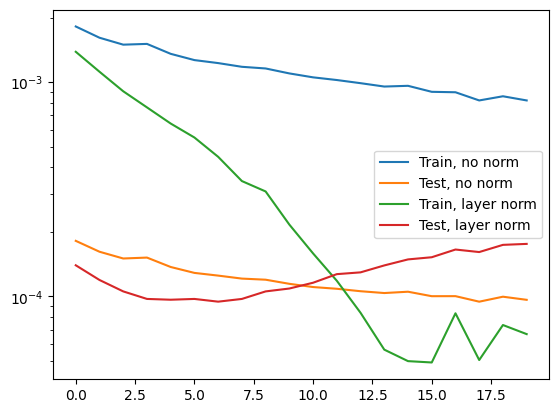

In [ ]:
plt.plot(train_cnn_epoch, label="Train, no norm")
plt.plot(test_cnn_epoch, label="Test, no norm")
plt.plot(epoch_train_loss_layernorm, label="Train, layer norm")
plt.plot(epoch_test_loss_layernorm, label="Test, layer norm")
plt.legend()
plt.yscale("log")

In [ ]:
cnn_batch = NormalizedCNN(initial_cnn_model, "batch_norm").to(device)
adam_opt_cnn_batch = torch.optim.Adam(cnn_batch.parameters(), lr=lr)
conv_cnn_batch = []

In [ ]:
cnn_batch

In [ ]:
epoch_train_loss_batchnorm = []
epoch_test_loss_batchnorm = []

In [ ]:
for epoch in range(1, n_epoch + 1):
  cur_conv = train(cnn_batch, train_loader, adam_opt_cnn_batch, epoch, log_interval)
  conv_cnn_batch = conv_cnn_batch + cur_conv
  cur_train_loss, cur_test_loss = test(cnn_batch, test_loader, train_loader)
  epoch_train_loss_batchnorm.append(cur_train_loss)
  epoch_test_loss_batchnorm.append(cur_test_loss)

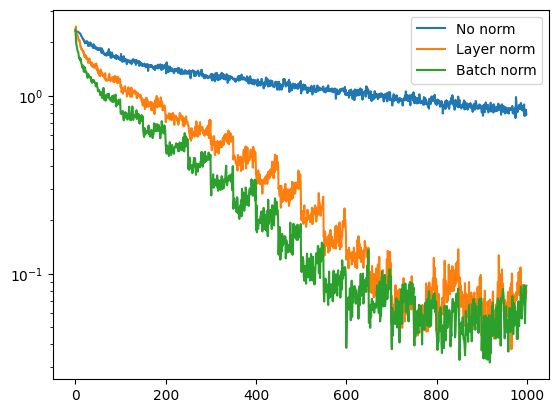

In [ ]:
plt.plot(conv_cnn_no_norm, label="No norm")
plt.plot(conv_cnn_layer, label="Layer norm")
plt.plot(conv_cnn_batch, label="Batch norm")
plt.yscale("log")
plt.legend()

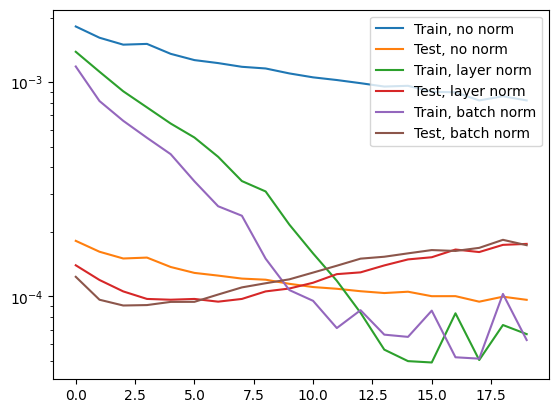

In [ ]:
plt.plot(train_cnn_epoch, label="Train, no norm")
plt.plot(test_cnn_epoch, label="Test, no norm")
plt.plot(epoch_train_loss_layernorm, label="Train, layer norm")
plt.plot(epoch_test_loss_layernorm, label="Test, layer norm")
plt.plot(epoch_train_loss_batchnorm, label="Train, batch norm")
plt.plot(epoch_test_loss_batchnorm, label="Test, batch norm")
plt.legend()
plt.yscale("log")